In [1]:
from scipy.signal import lfilter
from scipy import integrate
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#import matplotlib.gridspec as gridspec
#import seaborn as sns

# Constants
G_TO_MPS2 = 9.81
Q = 10


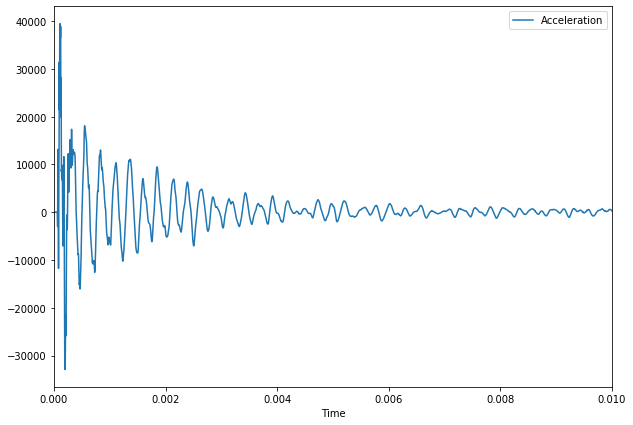

In [28]:
path = 'C:/Users/steph/Documents/Python Scripts/plateXacceleration.txt'
data_df = pd.read_csv(path,sep='\t' )
data_df.head()
T = np.diff(data_df['Time']).mean() #mean time  between data points
data_df.plot(x = 'Time', y = 'Acceleration', figsize = (10,7))
plt.show()


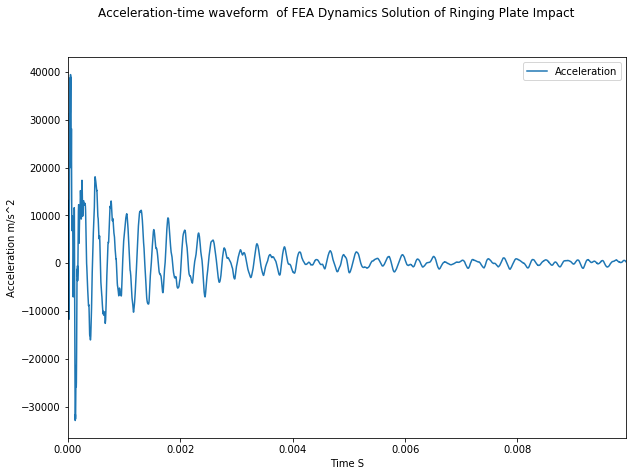

In [29]:
# remove leading zero lines

W = next(x[0] for x in enumerate(data_df['Acceleration']) if x[1] > 0.7)

data_df['Acceleration'] = data_df['Acceleration'].shift(-W+1)

data_df.drop(data_df.tail(W+1).index,inplace=True)
data_df.plot(x = 'Time', y = 'Acceleration', figsize = (10,7))
plt.suptitle('Acceleration-time waveform  of FEA Dynamics Solution of Ringing Plate Impact ')
plt.xlabel('Time S')
plt.ylabel('Acceleration m/s^2')
plt.show()

In [30]:
def freq_array(fn_start = 10., fn_end = 1.0e4, oct_step_size = (1./12.)):
    fn_array = [fn_start]
    for i in range(int(fn_end-fn_start)):
        new_fn = (fn_start*2.**(oct_step_size))
        fn_array.append(new_fn)
        fn_start = new_fn
        if fn_start > fn_end:
            break
    fn_array = np.array(fn_array)
    return fn_array

Frequency = freq_array()


In [31]:
damp = 1/(2*Q)
T = np.diff(data_df.Time.values).mean() # sample interval
omega_n = 2. * np.pi * Frequency
omega_d = omega_n * np.sqrt(1 - damp**2.)
E = np.exp(-damp * omega_n * T)
K = T*omega_d
C = E*np.cos(K)
S = E*np.sin(K)
S_prime = S/K
b0 = 1. - S_prime
b1 = 2. * (S_prime - C)
b2 = E**2. - S_prime
a0 = np.ones_like(Frequency) # Necessary because of how scipy.signal.lfilter() is structured
a1 = -2. * C
a2 = E**2.
b = np.array([b0,b1,b2]).T
a = np.array([a0,a1,a2]).T

In [32]:
pos_accel = np.zeros_like(Frequency)
neg_accel = np.zeros_like(Frequency)
for i,f_n in enumerate(Frequency):
    output_accel_g = lfilter(b[i], a[i], data_df['Acceleration'])
    pos_accel[i] = output_accel_g.max()
    neg_accel[i] = np.abs(output_accel_g.min())
results = {'frequency':Frequency,'pos_accel':pos_accel,'neg_accel':neg_accel}
result_df =pd.DataFrame(results)
result_df.head()

,frequency,pos_accel,neg_accel
0,10.000000,165.272567,0.018884
1,10.594631,182.113497,0.020007
2,11.224620,200.559552,0.021197
3,11.892071,220.722204,0.022458
4,12.599210,242.708651,0.023795


121
4966
121


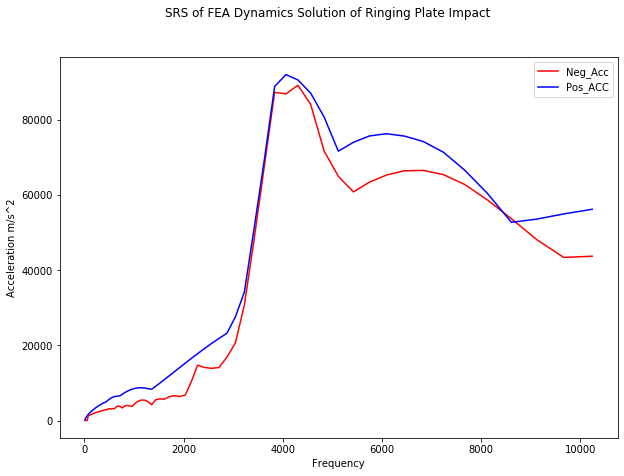

In [33]:
print (len (neg_accel))
print (len(data_df.Acceleration))
print (len(Frequency))
plt.figure(figsize=(10, 7))
plt.suptitle('SRS of FEA Dynamics Solution of Ringing Plate Impact ')
plt.xlabel('Frequency')
plt.ylabel('Acceleration m/s^2')

plt.plot(result_df['frequency'], result_df['neg_accel'], color = 'red', label ='Neg_Acc')
plt.plot(result_df['frequency'], result_df['pos_accel'], color = 'blue', label = 'Pos_ACC')
plt.legend()
plt.show()